# Medical Imaging
### 14 June 2022
### Lab 6

Consider the study of a homogenous sample with T1/T2 = 600/60 ms, using a saturation-recovery NMR pulse sequence, with an excitation flip angle of 65°, TE/TR = 1/900 ms and a total number of excitations / repetitions NEX = 10.

#### 1. Draw the pulse sequence diagram (including indication of the RF pulses, signal acquisition times, TE and TR).

#### 2. Compute the total study duration.

Total duration = $NEX * TR$ = $ 10 * 900ms$ = $9s$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
delT = 1 / 1000
T1 = 600 / 1000
T2 = 60 / 1000 
TE = 1 / 1000
TR = 900 / 1000
g = 42.58 * (10**6)

In [3]:
def excitation(direction, t, delT, gyr, theta, M_0):
    theta = np.deg2rad(theta)
    B_1 = theta / (gyr * t)
    phi = gyr*B_1*delT

    if direction == "x":
        rotMat = [[1, 0, 0], [0, np.cos(phi), np.sin(phi)], [0, -np.sin(phi), np.cos(phi)]]
    if direction == "y":
        rotMat = [[np.cos(phi), 0, -np.sin(phi)], [0, 1, 0], [np.sin(phi), 0, np.cos(phi)]]
    if direction == "z":
        rotMat = [[np.cos(phi), np.sin(phi), 0], [-np.sin(phi), np.cos(phi), 0], [0, 0, 1]]
    
    m = M_0
    mX = [M_0[0]]
    mY = [M_0[1]]
    mZ = [M_0[2]]
    
    for i in range(0, int(t/delT)):
        m = np.matmul(rotMat, m)
        
        mX = np.append(mX, m[0])
        mY = np.append(mY, m[1])
        mZ = np.append(mZ, m[2])
        
    return [mX, mY, mZ]  

In [4]:
def relaxation(t, delT, T_1, T_2, M_0):
    m = M_0
    mX = [M_0[0]]
    mY = [M_0[1]]
    mZ = [M_0[2]]
    relaxMat = [[np.exp(-(delT / T_2)), 0 , 0], [0, np.exp(-(delT / T_2)), 0], [0, 0, np.exp(-(delT / T_1))]]

    
    for j in range(1, int(t / delT)):
        m = np.matmul(relaxMat, m) + [0, 0, (np.linalg.norm([0, 0, 1])*(1 - np.exp(-delT / T_1)))]
        
        mX = np.append(mX, m[0])
        mY = np.append(mY, m[1])
        mZ = np.append(mZ, m[2])
        
    return [mX, mY, mZ]    

In [5]:
def repeats(reps, direction, tExc, delT, gyr, theta, M_0, tRel, T_1, T_2):
    mFinalX = np.array([])
    mFinalY = np.array([])
    mFinalZ = np.array([])

    m = M0
    for i in range(reps):
        mExcitedX, mExcitedY, mExcitedZ = excitation(direction, tExc, delT, gyr, theta, m)
        mExcited = [mExcitedX[-1], mExcitedY[-1], mExcitedZ[-1]]
        mRelaxedX, mRelaxedY, mRelaxedZ = relaxation(tRel, delT, T1, T2, mExcited)

        m = [mRelaxedX[-1], mRelaxedY[-1], mRelaxedZ[-1]]

        mFinalX = np.append(mFinalX, np.concatenate((mExcitedX, mRelaxedX)))
        mFinalY = np.append(mFinalY, np.concatenate((mExcitedY, mRelaxedY)))
        mFinalZ = np.append(mFinalZ, np.concatenate((mExcitedZ, mRelaxedZ)))
        
    return [mFinalX, mFinalY, mFinalZ]

In [6]:
def steadyStateZ(M_0, TR, T_1, theta):
    theta = np.deg2rad(theta)
    mZ = (np.linalg.norm(M_0)*(1 - np.exp(-TR/T_1))) / (1 - (np.exp(-TR/T_1)*np.cos(theta)))
    return mZ

In [7]:
def steadyStateXY(M_0, TR, TE, T_1, T_2, theta):
    theta = np.deg2rad(theta)
    mXY = ((np.linalg.norm(M_0)*(1 - np.exp(-TR/T_1))*np.sin(theta)) / (1 - (np.exp(-TR/T_1)*np.cos(theta))))*np.exp(-TE/T_2)
    return mXY


In [8]:
def amplitude(mFinalX, mFinalZ, TR, NEX):
    ampZ = []
    ampXY = []
    TR = int(TR*1000)
    print(len(mFinalZ))
    for i in range(0, NEX):
        ampZ.append(max(mFinalZ[i*TR:(i+1)*TR]))
        ampXY.append(min(mFinalX[i*TR:(i+1)*TR]))

    plt.figure("Z")
    plt.plot(ampZ)
    
#     print(ampZ)

    plt.figure("X")
    plt.plot(ampXY)

#### In the following simulations, use the rotating reference frame and a time step of 1 ms. Consider on-resonance spins and the equilibrium magnetization vector M0 = [0; 0; 1]

#### 3. Simulate the evolution of the longitudinal and transverse magnetization during the sequence.

In [9]:
M0 = [0, 0, 1]
direction = "y"
theta = 65

mFinalX, mFinalY, mFinalZ = repeats(10, direction, TE, delT, g, theta, M0, TR - TE, T1, T2)

[ 0.00000000e+00 -9.06307787e-01 -9.06307787e-01 ... -2.54044125e-07
 -2.49845145e-07 -2.45715568e-07]


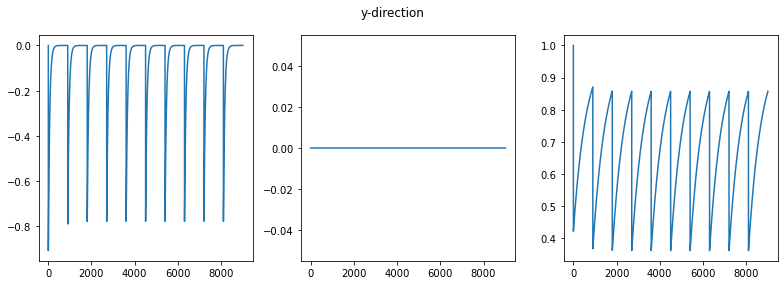

In [10]:
print(mFinalX)
plt.figure(direction, figsize=(11, 4))
plt.suptitle(direction + "-direction")

plt.subplot(1, 3, 1)
plt.plot(mFinalX)

plt.subplot(1, 3, 2)
plt.plot(mFinalY)

plt.subplot(1, 3, 3)
plt.plot(mFinalZ)

plt.tight_layout()

#### 4. Indicate which component of the magnetization is measured and plot its amplitude at each acquisition time.

9010


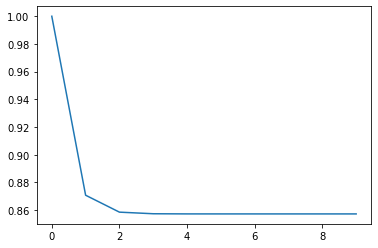

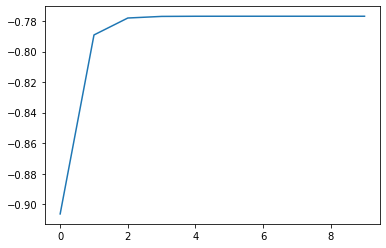

In [11]:
amplitude(mFinalX, mFinalZ, 900/1000, 10)

#### 5. Calculate the steady-state magnetization, Mss, and determine this from the data.

$$ M_{z^-} = \frac{M_0 \left [ 1 - exp ( - TR/T_1) \right]}{1 - exp(-TR/T_1) cos \theta} $$ 
<br>
$$ M_{xy^{+}} = \frac{M_0 \left [ 1 - exp ( - TR/T_1) \right] sin \theta}{1 - exp(-TR/T_1) cos \theta} \cdot exp \left( - \frac{TE}{T_2^{(*)}} \right ) $$

In [12]:
TR = 900 / 1000
T1 = 600 / 1000
theta = 65
T2 = 60/1000
steadyStateZ([0, 0 ,1], TR, T1, theta)


0.8577551943571987

In [13]:
steadyStateXY([0, 0, 1], TR, TE, T1, T2, theta)

0.7645410819991177

#### 6. Repeat 3 - 5, if TR is reduced to 90 ms and NEX is increased to 100 (yielding the same total study duration).

In [14]:
M0 = [0, 0, 1]
direction = "y"
theta = 65

delT = 1 / 1000
T1 = 600 / 1000
T2 = 60 / 1000 
TE = 1 / 1000
TR = 90 / 1000
g = 42.58 * (10**6)

mFinalX, mFinalY, mFinalZ = repeats(100, direction, TE, delT, g, theta, M0, TR - TE, T1, T2)

[ 0.         -0.90630779 -0.90630779 ... -0.04002508 -0.03936352
 -0.0387129 ]


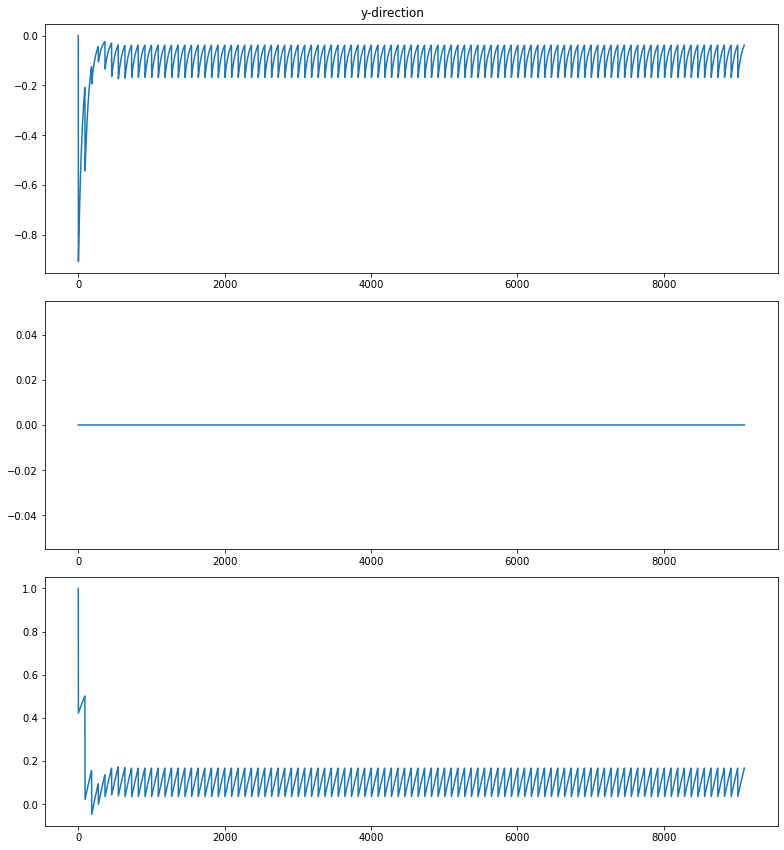

In [15]:
print(mFinalX)
plt.figure(direction, figsize=(11, 12))
plt.suptitle(direction + "-direction")

plt.subplot(3, 1, 1)
plt.plot(mFinalX)

plt.subplot(3, 1, 2)
plt.plot(mFinalY)

plt.subplot(3, 1, 3)
plt.plot(mFinalZ)

plt.tight_layout()

9100


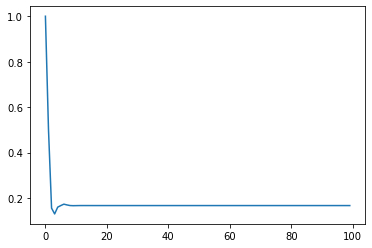

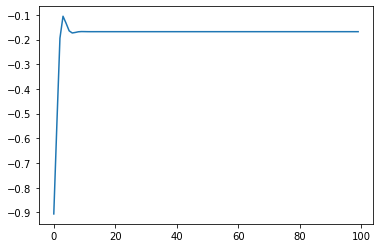

In [16]:
amplitude(mFinalX, mFinalZ, 90/1000, 100)

In [17]:
TR = 90 / 1000
T1 = 600 / 1000
theta = 65
T2 = 60/1000
steadyStateZ([0, 0 ,1], TR, T1, theta)

0.21892687237642577

In [18]:
steadyStateXY([0, 0, 1], TR, TE, T1, T2, theta)

0.1951356156004263

#### 7. Compute the Ernst angle, the flip angle that maximizes the value of Mss, for each TR value considered. Verify that the given value of 65° is close to optimal for TR = 900 ms but not TR = 90 ms.

    
$$cos (\theta_{Ernst}) = - \exp(-TR/T_1)$$


The Ernst angle that maximises $M_{ss}$ for TR = 900ms:

In [19]:
TR = (900/1000)
T1 = (600/1000)
thetaErnst900 = np.rad2deg(np.pi - np.arccos(-np.exp(-TR/T1)))
(thetaErnst900)

77.10705082214434

The Ernst angle that maximises $M_{ss}$ for TR = 90ms:

In [20]:
TR = (90/1000)
T1 = (600/1000)
thetaErnst90 = np.rad2deg(np.pi - np.arccos(-np.exp(-TR/T1)))
(thetaErnst90)

30.60383238785675

#### 8. Repeat 6 using the Ernst angle for TR = 90 ms.

In [21]:
M0 = [0, 0, 1]
direction = "y"
theta = thetaErnst90

delT = 1 / 1000
T1 = 600 / 1000
T2 = 60 / 1000 
TE = 1 / 1000
TR = 90 / 1000
g = 42.58 * (10**6)

mFinalX, mFinalY, mFinalZ = repeats(100, direction, TE, delT, g, thetaErnst90, M0, TR - TE, T1, T2)

[ 0.         -0.50909899 -0.50909899 ... -0.06436145 -0.06329765
 -0.06225143]


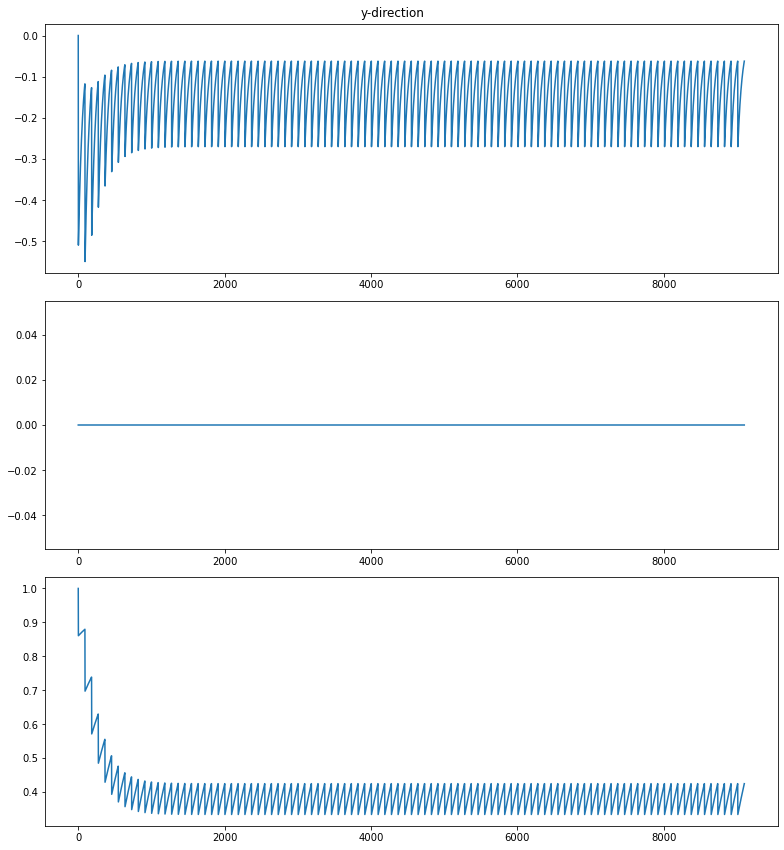

In [22]:
print(mFinalX)
plt.figure(direction, figsize=(11, 12))
plt.suptitle(direction + "-direction")

plt.subplot(3, 1, 1)
plt.plot(mFinalX)

plt.subplot(3, 1, 2)
plt.plot(mFinalY)

plt.subplot(3, 1, 3)
plt.plot(mFinalZ)

plt.tight_layout()

9100


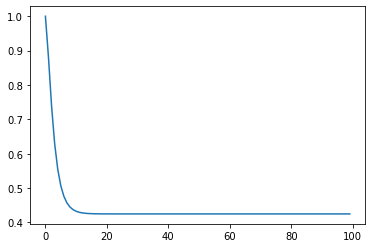

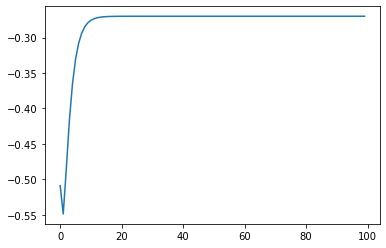

In [23]:
amplitude(mFinalX, mFinalZ, 90/1000, 100)

In [24]:
TR = 90 / 1000
T1 = 600 / 1000
theta = thetaErnst90
T2 = 60/1000
steadyStateZ([0, 0 ,1], TR, T1, theta)

0.5374298453437498

In [25]:
steadyStateXY([0, 0, 1], TR, TE, T1, T2, theta)

0.26908269753005676

#### 9. Indicate how the SNR varies with NEX, and compare the overall SNR per unit time of Mss in 6 vs. 5 and 8 vs. 5.

In [31]:
snr6_5 = (np.sqrt(100)*0.21892687237642577)/(np.sqrt(10)*0.8577551943571987)
snr8_5 = (np.sqrt(100)*0.5374298453437498)/(np.sqrt(10)*0.8577551943571987)
print(snr6_5)
print(snr8_5)

0.807115552643572
1.9813373384604138
